In [1]:
import pandas as pd
from dfply import *
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D,Dense,Flatten
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.decomposition import PCA

print(tf.__version__)

if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")
  

2.1.0
Default GPU Device: /device:GPU:0


In [2]:
df = pd.read_csv("E:\\ProjectData\\ERAU-REU\\Project-Drone-Behavior\\behavior-captures\\behavior-signal-multiple-processed.csv")

In [3]:
#plot = df.plot(legend=False)
#plot.figure.savefig("E:\\ProjectData\\ERAU-REU\\Project-Drone-Behavior\\plots\\allplot.png")

In [4]:
#plot = videoDf.plot(legend=False)
#plot.figure.savefig("E:\\ProjectData\\ERAU-REU\\Project-Drone-Behavior\\plots\\allVideoPlot.png")

In [5]:
df >>= mutate(drone_present = case_when([df.behavior == 'surround','yes'],
[df.behavior == 'straight','yes'],
[df.behavior == 'noise','no']))
presence_labs = df['drone_present']

In [6]:
values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

y.shape

(3200, 2)

In [7]:
x = df.drop(['behavior','signal','multiple','drone_present'],axis=1).values

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
model_large = keras.Sequential(name='test')
model_large.add(Dense(64, activation='relu', input_shape=(1280,)))
model_large.add(Dense(32, activation='relu'))
model_large.add(Dense(2, activation='sigmoid'))

In [10]:
model_large.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_large.build(input_shape=(1280,))
model_large.summary()

Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 84,130
Trainable params: 84,130
Non-trainable params: 0
_________________________________________________________________


In [11]:
fit_all = model_large.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 32,
        validation_split = .2,
        verbose=True)

Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 1s 290us/sample - loss: 0.6873 - accuracy: 0.4902 - val_loss: 0.6789 - val_accuracy: 0.5811
Epoch 2/100
2048/2048 [==============================] - 0s 51us/sample - loss: 0.6734 - accuracy: 0.6079 - val_loss: 0.6677 - val_accuracy: 0.6133
Epoch 3/100
2048/2048 [==============================] - 0s 50us/sample - loss: 0.6621 - accuracy: 0.6218 - val_loss: 0.6579 - val_accuracy: 0.6152
Epoch 4/100
2048/2048 [==============================] - 0s 50us/sample - loss: 0.6523 - accuracy: 0.6255 - val_loss: 0.6492 - val_accuracy: 0.6162
Epoch 5/100
2048/2048 [==============================] - 0s 52us/sample - loss: 0.6436 - accuracy: 0.6274 - val_loss: 0.6413 - val_accuracy: 0.6152
Epoch 6/100
2048/2048 [==============================] - 0s 50us/sample - loss: 0.6358 - accuracy: 0.6274 - val_loss: 0.6341 - val_accuracy: 0.6152
Epoch 7/100
2048/2048 [==============================] - 0s 50us

In [12]:
prediction = model_large.predict(x_test)
prediction_df = pd.DataFrame(prediction, columns=['prob_present','prob_not_present']) 

In [13]:
y_test = pd.DataFrame(y_test,columns=['present','not_present'])

y_pred = y_test >> bind_cols(prediction_df)

y_pred >>= mutate(actual = case_when([y_pred.present == 1, 'present'],
[y_pred.not_present == 1, 'not_present']),
predicted = case_when([y_pred.prob_present > y_pred.prob_not_present, 'present'],
[y_pred.prob_present < y_pred.prob_not_present, 'not_present']))

y_pred >>= mutate(correct = case_when([y_pred.actual == y_pred.predicted, 'yes'],
[y_pred.actual != y_pred.predicted, 'no']),
feature = 'all')
y_pred


,present,not_present,prob_present,prob_not_present,actual,predicted,correct,feature
0,0.0,1.0,0.136889,0.864184,not_present,not_present,yes,all
1,0.0,1.0,0.198516,0.795845,not_present,not_present,yes,all
2,0.0,1.0,0.162797,0.835352,not_present,not_present,yes,all
3,1.0,0.0,0.149262,0.844731,present,not_present,no,all
4,0.0,1.0,0.174247,0.813663,not_present,not_present,yes,all
...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.168411,0.835854,not_present,not_present,yes,all
636,0.0,1.0,0.152016,0.835837,not_present,not_present,yes,all
637,0.0,1.0,0.157270,0.847382,not_present,not_present,yes,all
638,0.0,1.0,0.035570,0.972761,not_present,not_present,yes,all


In [14]:
small_df = df[df.columns[0:256]]
small_df >>= bind_cols(df.drone_present)

presence_labs = small_df['drone_present']

values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

x = small_df.drop(['drone_present'],axis=1).values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model_small = keras.Sequential(name='test')
model_small.add(Dense(64, activation='relu', input_shape=(256,)))
model_small.add(Dense(32, activation='relu'))
model_small.add(Dense(2, activation='sigmoid'))

model_small.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_small.build(input_shape=(256,))
model_small.summary()

fit1 = model_small.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 32,
        validation_split = .2,
        verbose=True)

prediction = model_small.predict(x_test)
prediction_df = pd.DataFrame(prediction, columns=['prob_present','prob_not_present']) 

y_test = pd.DataFrame(y_test,columns=['present','not_present'])

y_pred = y_test >> bind_cols(prediction_df)

y_pred >>= mutate(actual = case_when([y_pred.present == 1, 'present'],
[y_pred.not_present == 1, 'not_present']),
predicted = case_when([y_pred.prob_present > y_pred.prob_not_present, 'present'],
[y_pred.prob_present < y_pred.prob_not_present, 'not_present']))

y_pred >>= mutate(correct = case_when([y_pred.actual == y_pred.predicted, 'yes'],
[y_pred.actual != y_pred.predicted, 'no']),
feature = 'imf_1')
y_pred



Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 18,594
Trainable params: 18,594
Non-trainable params: 0
_________________________________________________________________
Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 0s 179us/sample - loss: 0.6875 - accuracy: 0.5537 - val_loss: 0.6797 - val_accuracy: 0.5996
Epoch 2/100
2048/2048 [==============================] - 0s 48us/sample - loss: 0.6761 - accuracy: 0.5913 - val_loss: 0.6720 - val_accuracy: 0.5996
Epoch 3/100
2048/2048 [=====================

,present,not_present,prob_present,prob_not_present,actual,predicted,correct,feature
0,0.0,1.0,0.237451,0.739642,not_present,not_present,yes,imf_1
1,1.0,0.0,0.716398,0.334916,present,present,yes,imf_1
2,0.0,1.0,0.399759,0.590905,not_present,not_present,yes,imf_1
3,0.0,1.0,0.264118,0.708033,not_present,not_present,yes,imf_1
4,0.0,1.0,0.212785,0.776766,not_present,not_present,yes,imf_1
...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.278924,0.807757,present,not_present,no,imf_1
636,1.0,0.0,0.731530,0.322220,present,present,yes,imf_1
637,1.0,0.0,0.663550,0.380602,present,present,yes,imf_1
638,0.0,1.0,0.284572,0.688631,not_present,not_present,yes,imf_1


In [15]:
small_df = df[df.columns[256:512]]
small_df >>= bind_cols(df.drone_present)

presence_labs = small_df['drone_present']

values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

x = small_df.drop(['drone_present'],axis=1).values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

fit2 = model_small.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 32,
        validation_split = .2,
        verbose=True)

prediction = model_small.predict(x_test)
prediction_df = pd.DataFrame(prediction, columns=['prob_present','prob_not_present']) 

y_test = pd.DataFrame(y_test,columns=['present','not_present'])

y_pred = y_test >> bind_cols(prediction_df)

y_pred >>= mutate(actual = case_when([y_pred.present == 1, 'present'],
[y_pred.not_present == 1, 'not_present']),
predicted = case_when([y_pred.prob_present > y_pred.prob_not_present, 'present'],
[y_pred.prob_present < y_pred.prob_not_present, 'not_present']))

y_pred >>= mutate(correct = case_when([y_pred.actual == y_pred.predicted, 'yes'],
[y_pred.actual != y_pred.predicted, 'no']),
feature = 'imf_2')
y_pred




Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 0s 62us/sample - loss: 0.5279 - accuracy: 0.8411 - val_loss: 0.5069 - val_accuracy: 0.8271
Epoch 2/100
2048/2048 [==============================] - 0s 60us/sample - loss: 0.4993 - accuracy: 0.8406 - val_loss: 0.4939 - val_accuracy: 0.8281
Epoch 3/100
2048/2048 [==============================] - 0s 52us/sample - loss: 0.4836 - accuracy: 0.8467 - val_loss: 0.4858 - val_accuracy: 0.8359
Epoch 4/100
2048/2048 [==============================] - 0s 56us/sample - loss: 0.4730 - accuracy: 0.8586 - val_loss: 0.4784 - val_accuracy: 0.8457
Epoch 5/100
2048/2048 [==============================] - 0s 51us/sample - loss: 0.4648 - accuracy: 0.8623 - val_loss: 0.4733 - val_accuracy: 0.8496
Epoch 6/100
2048/2048 [==============================] - 0s 51us/sample - loss: 0.4582 - accuracy: 0.8669 - val_loss: 0.4688 - val_accuracy: 0.8496
Epoch 7/100
2048/2048 [==============================] - 0s 51us/

,present,not_present,prob_present,prob_not_present,actual,predicted,correct,feature
0,0.0,1.0,0.168916,0.824937,not_present,not_present,yes,imf_2
1,0.0,1.0,0.146301,0.850568,not_present,not_present,yes,imf_2
2,1.0,0.0,0.976649,0.035136,present,present,yes,imf_2
3,0.0,1.0,0.196313,0.811291,not_present,not_present,yes,imf_2
4,1.0,0.0,0.972681,0.039702,present,present,yes,imf_2
...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.975785,0.051501,not_present,present,no,imf_2
636,0.0,1.0,0.167533,0.820990,not_present,not_present,yes,imf_2
637,0.0,1.0,0.160948,0.821174,not_present,not_present,yes,imf_2
638,1.0,0.0,0.168828,0.822900,present,not_present,no,imf_2


In [16]:
small_df = df[df.columns[512:768]]
small_df >>= bind_cols(df.drone_present)

presence_labs = small_df['drone_present']

values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

x = small_df.drop(['drone_present'],axis=1).values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

fit3 = model_small.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 32,
        validation_split = .2,
        verbose=True)

prediction = model_small.predict(x_test)
prediction_df = pd.DataFrame(prediction, columns=['prob_present','prob_not_present']) 

y_test = pd.DataFrame(y_test,columns=['present','not_present'])

y_pred = y_test >> bind_cols(prediction_df)

y_pred >>= mutate(actual = case_when([y_pred.present == 1, 'present'],
[y_pred.not_present == 1, 'not_present']),
predicted = case_when([y_pred.prob_present > y_pred.prob_not_present, 'present'],
[y_pred.prob_present < y_pred.prob_not_present, 'not_present']))

y_pred >>= mutate(correct = case_when([y_pred.actual == y_pred.predicted, 'yes'],
[y_pred.actual != y_pred.predicted, 'no']),
feature = 'imf_3')
y_pred



Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 0s 53us/sample - loss: 0.4351 - accuracy: 0.8137 - val_loss: 0.4021 - val_accuracy: 0.8242
Epoch 2/100
2048/2048 [==============================] - 0s 47us/sample - loss: 0.4024 - accuracy: 0.8416 - val_loss: 0.3965 - val_accuracy: 0.8428
Epoch 3/100
2048/2048 [==============================] - 0s 48us/sample - loss: 0.3978 - accuracy: 0.8486 - val_loss: 0.3938 - val_accuracy: 0.8428
Epoch 4/100
2048/2048 [==============================] - 0s 49us/sample - loss: 0.3964 - accuracy: 0.8481 - val_loss: 0.3922 - val_accuracy: 0.8438
Epoch 5/100
2048/2048 [==============================] - 0s 50us/sample - loss: 0.3936 - accuracy: 0.8491 - val_loss: 0.3904 - val_accuracy: 0.8438
Epoch 6/100
2048/2048 [==============================] - 0s 50us/sample - loss: 0.3927 - accuracy: 0.8499 - val_loss: 0.3892 - val_accuracy: 0.8447
Epoch 7/100
2048/2048 [==============================] - 0s 48us/

,present,not_present,prob_present,prob_not_present,actual,predicted,correct,feature
0,0.0,1.0,0.135586,0.863920,not_present,not_present,yes,imf_3
1,0.0,1.0,0.190671,0.803014,not_present,not_present,yes,imf_3
2,0.0,1.0,0.383367,0.631783,not_present,not_present,yes,imf_3
3,0.0,1.0,0.136931,0.856289,not_present,not_present,yes,imf_3
4,0.0,1.0,0.153871,0.850087,not_present,not_present,yes,imf_3
...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.993823,0.008410,present,present,yes,imf_3
636,0.0,1.0,0.216730,0.781095,not_present,not_present,yes,imf_3
637,0.0,1.0,0.150244,0.846555,not_present,not_present,yes,imf_3
638,1.0,0.0,0.145910,0.854962,present,not_present,no,imf_3


In [17]:
small_df = df[df.columns[768:1024]]
small_df >>= bind_cols(df.drone_present)

presence_labs = small_df['drone_present']

values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

x = small_df.drop(['drone_present'],axis=1).values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

fit4 = model_small.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 32,
        validation_split = .2,
        verbose=True)

prediction = model_small.predict(x_test)
prediction_df = pd.DataFrame(prediction, columns=['prob_present','prob_not_present']) 

y_test = pd.DataFrame(y_test,columns=['present','not_present'])

y_pred = y_test >> bind_cols(prediction_df)

y_pred >>= mutate(actual = case_when([y_pred.present == 1, 'present'],
[y_pred.not_present == 1, 'not_present']),
predicted = case_when([y_pred.prob_present > y_pred.prob_not_present, 'present'],
[y_pred.prob_present < y_pred.prob_not_present, 'not_present']))

y_pred >>= mutate(correct = case_when([y_pred.actual == y_pred.predicted, 'yes'],
[y_pred.actual != y_pred.predicted, 'no']),
feature = 'imf_4')
y_pred


Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 0s 53us/sample - loss: 0.5015 - accuracy: 0.7756 - val_loss: 0.3757 - val_accuracy: 0.8477
Epoch 2/100
2048/2048 [==============================] - 0s 48us/sample - loss: 0.4183 - accuracy: 0.8262 - val_loss: 0.3638 - val_accuracy: 0.8535
Epoch 3/100
2048/2048 [==============================] - 0s 49us/sample - loss: 0.4137 - accuracy: 0.8281 - val_loss: 0.3626 - val_accuracy: 0.8525
Epoch 4/100
2048/2048 [==============================] - 0s 51us/sample - loss: 0.4112 - accuracy: 0.8315 - val_loss: 0.3628 - val_accuracy: 0.8555
Epoch 5/100
2048/2048 [==============================] - 0s 51us/sample - loss: 0.4098 - accuracy: 0.8318 - val_loss: 0.3606 - val_accuracy: 0.8623
Epoch 6/100
2048/2048 [==============================] - 0s 49us/sample - loss: 0.4091 - accuracy: 0.8320 - val_loss: 0.3600 - val_accuracy: 0.8613
Epoch 7/100
2048/2048 [==============================] - 0s 48us/

,present,not_present,prob_present,prob_not_present,actual,predicted,correct,feature
0,0.0,1.0,0.163446,0.838162,not_present,not_present,yes,imf_4
1,1.0,0.0,0.163396,0.839083,present,not_present,no,imf_4
2,0.0,1.0,0.065234,0.959768,not_present,not_present,yes,imf_4
3,1.0,0.0,0.216368,0.786270,present,not_present,no,imf_4
4,0.0,1.0,0.131921,0.867549,not_present,not_present,yes,imf_4
...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.993379,0.007508,present,present,yes,imf_4
636,1.0,0.0,0.185032,0.815659,present,not_present,no,imf_4
637,1.0,0.0,0.998716,0.000873,present,present,yes,imf_4
638,0.0,1.0,0.388044,0.597987,not_present,not_present,yes,imf_4


In [18]:
small_df = df[df.columns[1024:1280]]
small_df >>= bind_cols(df.drone_present)

presence_labs = small_df['drone_present']

values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

x = small_df.drop(['drone_present'],axis=1).values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

fit5 = model_small.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 32,
        validation_split = .2,
        verbose=True)

prediction = model_small.predict(x_test)
prediction_df = pd.DataFrame(prediction, columns=['prob_present','prob_not_present']) 

y_test = pd.DataFrame(y_test,columns=['present','not_present'])

y_pred = y_test >> bind_cols(prediction_df)

y_pred >>= mutate(actual = case_when([y_pred.present == 1, 'present'],
[y_pred.not_present == 1, 'not_present']),
predicted = case_when([y_pred.prob_present > y_pred.prob_not_present, 'present'],
[y_pred.prob_present < y_pred.prob_not_present, 'not_present']))

y_pred >>= mutate(correct = case_when([y_pred.actual == y_pred.predicted, 'yes'],
[y_pred.actual != y_pred.predicted, 'no']),
feature = 'imf_5')
y_pred



Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 0s 54us/sample - loss: 0.3897 - accuracy: 0.8398 - val_loss: 0.4057 - val_accuracy: 0.8301
Epoch 2/100
2048/2048 [==============================] - 0s 48us/sample - loss: 0.3737 - accuracy: 0.8523 - val_loss: 0.4020 - val_accuracy: 0.8320
Epoch 3/100
2048/2048 [==============================] - 0s 52us/sample - loss: 0.3717 - accuracy: 0.8535 - val_loss: 0.3989 - val_accuracy: 0.8320
Epoch 4/100
2048/2048 [==============================] - 0s 56us/sample - loss: 0.3717 - accuracy: 0.8545 - val_loss: 0.4019 - val_accuracy: 0.8340
Epoch 5/100
2048/2048 [==============================] - 0s 59us/sample - loss: 0.3713 - accuracy: 0.8555 - val_loss: 0.3977 - val_accuracy: 0.8389
Epoch 6/100
2048/2048 [==============================] - 0s 66us/sample - loss: 0.3710 - accuracy: 0.8560 - val_loss: 0.3970 - val_accuracy: 0.8389
Epoch 7/100
2048/2048 [==============================] - 0s 60us/

,present,not_present,prob_present,prob_not_present,actual,predicted,correct,feature
0,0.0,1.0,0.121820,0.878875,not_present,not_present,yes,imf_5
1,1.0,0.0,0.995807,0.004531,present,present,yes,imf_5
2,0.0,1.0,0.157295,0.843426,not_present,not_present,yes,imf_5
3,0.0,1.0,0.170885,0.830069,not_present,not_present,yes,imf_5
4,0.0,1.0,0.162006,0.838424,not_present,not_present,yes,imf_5
...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.993923,0.006557,present,present,yes,imf_5
636,0.0,1.0,0.139798,0.854986,not_present,not_present,yes,imf_5
637,1.0,0.0,0.995972,0.004365,present,present,yes,imf_5
638,1.0,0.0,0.979417,0.021836,present,present,yes,imf_5


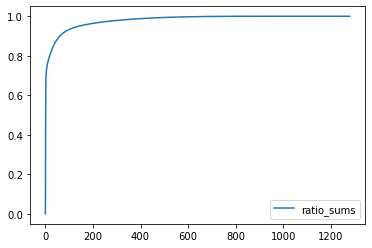

In [19]:
x = df.drop(['behavior','signal','multiple','drone_present'],axis=1).values

pca = decomposition.PCA(n_components=1280)
pca.fit(x)
pca_x = pca.transform(x)

variance = []
for i in range(1280):
    variance.append(sum(pca.explained_variance_ratio_[0:i]))

variance = pd.DataFrame(variance,columns=['ratio_sums'])
variance.plot()

In [20]:
presence_labs = df['drone_present']

values = np.array(presence_labs)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

x = df.drop(['behavior','signal','multiple','drone_present'],axis=1).values

pca = decomposition.PCA(n_components=200)
pca.fit(x)
x = pca.transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model_pca = keras.Sequential(name='test')
model_pca.add(Dense(64, activation='relu', input_shape=(200,)))
model_pca.add(Dense(32, activation='relu'))
model_pca.add(Dense(2, activation='sigmoid'))

model_pca.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_pca.build(input_shape=(200,))
model_pca.summary()

fit_pca = model_pca.fit(x = x_train,
        y = y_train, 
        epochs = 100,
        batch_size = 32,
        validation_split = .2,
        verbose=True)

prediction = model_pca.predict(x_test)
prediction_df = pd.DataFrame(prediction, columns=['prob_present','prob_not_present']) 

y_test = pd.DataFrame(y_test,columns=['present','not_present'])

y_pred = y_test >> bind_cols(prediction_df)

y_pred >>= mutate(actual = case_when([y_pred.present == 1, 'present'],
[y_pred.not_present == 1, 'not_present']),
predicted = case_when([y_pred.prob_present > y_pred.prob_not_present, 'present'],
[y_pred.prob_present < y_pred.prob_not_present, 'not_present']))

y_pred >>= mutate(correct = case_when([y_pred.actual == y_pred.predicted, 'yes'],
[y_pred.actual != y_pred.predicted, 'no']),
feature = 'pca')
y_pred


Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                12864     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 15,010
Trainable params: 15,010
Non-trainable params: 0
_________________________________________________________________
Train on 2048 samples, validate on 512 samples
Epoch 1/100
2048/2048 [==============================] - 1s 247us/sample - loss: 0.6899 - accuracy: 0.6589 - val_loss: 0.6827 - val_accuracy: 0.7051
Epoch 2/100
2048/2048 [==============================] - 0s 49us/sample - loss: 0.6754 - accuracy: 0.7097 - val_loss: 0.6688 - val_accuracy: 0.7324
Epoch 3/100
2048/2048 [=====================

,present,not_present,prob_present,prob_not_present,actual,predicted,correct,feature
0,1.0,0.0,0.163459,0.827430,present,not_present,no,pca
1,1.0,0.0,0.989765,0.010213,present,present,yes,pca
2,1.0,0.0,0.166846,0.833190,present,not_present,no,pca
3,0.0,1.0,0.203723,0.804960,not_present,not_present,yes,pca
4,1.0,0.0,0.155582,0.848806,present,not_present,no,pca
...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.212918,0.774682,not_present,not_present,yes,pca
636,1.0,0.0,0.998865,0.001022,present,present,yes,pca
637,0.0,1.0,0.185018,0.822350,not_present,not_present,yes,pca
638,0.0,1.0,0.189441,0.822144,not_present,not_present,yes,pca
